In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.image as mpimg
from matplotlib import pyplot as PLT
from sklearn import preprocessing as p
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### PROJECT GOALS AND BUSINESS QUESTIONS

The ambitions for this project is to use the newly aquired Data Science skills and tools to analyze a dataset.

I specifically want to perform an Unsupervised Learning technique in the project,
investigating whether I can find interesting clusters in an unknown dataset. 

The Business questions posed are:

1) Can Unsupervised Learning methods be used for clustering data from the Kaggle Walmart dataset?
  (The dataset is originally posted for predicting sales, using time dimensions and other techniques)
  
2) Can I by using the pca method reduce dimensions on this dataset with acceptable results, 
   and will I be able to establish clear and sensible clusters for the dataset, to provide basis for business analysis?
   
3) Do the clusters provide me with valuable insight about the Walmart stores by grouping them differently than we do 
   by only using geography and store size?
   
4) Can we identify variables that have a significant impact on the stores with outstanding high or low weekly sales?   
   

###  UNDERSTANDING AND PREPARING DATA

The 3 relevant dataset from Kaggles Walmart case are read into dataframes. Not all available Kaggle Walmart datasets are used, as my project focuses on the main data and does not include time analysis or comparison with test data.


In [215]:
Train = pd.read_csv('Walmart/train.csv', delimiter= ',')      

In [216]:
Stores = pd.read_csv('Walmart/stores.csv', delimiter= ',')      

In [217]:
Features = pd.read_csv('Walmart/features.csv', delimiter= ',')      

Below is several cells with assessment of data, as they are unknown to me and no descriptions are given explicitly.
 
 I do frequent data assessment to ensure I understand the data and move forward correctly with cleaning.
 
 These assessment steps are kept in the code to remind of where these steps are useful.  

In [218]:
Train.head(10)
#Train.describe()
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


First cleaning step is to reformat the date column to datetype. I do this for 'Date' in both datasets. (Date column in Features is handled some cells below). NOte that I now have 2 columns, the original will be dropped after the conversion is done and confirmed.   

In [219]:
Train['Date'] = pd.to_datetime(Train['Date'])

In [81]:
Train.head()
#Train.info()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,0
1,1,1,2010-02-12,46039.49,1
2,1,1,2010-02-19,41595.55,0
3,1,1,2010-02-26,19403.54,0
4,1,1,2010-03-05,21827.90,0


The Date column is reformatted to 'week_no' to obtain a 'normal' float variable. 

In [220]:
Train['week_no'] = Train['Date'].dt.week
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 6 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
week_no         421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 16.5 MB


In [84]:
Train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,week_no
0,1,1,2010-02-05,24924.50,0,5
1,1,1,2010-02-12,46039.49,1,6
2,1,1,2010-02-19,41595.55,0,7
3,1,1,2010-02-26,19403.54,0,8
4,1,1,2010-03-05,21827.90,0,9


After date reformatting is done and confirmed, the original Date column is dropped.

In [221]:
colsdate = ['Date']
Train.drop(colsdate, axis=1, inplace=True)

In [222]:
Train.head()

,Store,Dept,Weekly_Sales,IsHoliday,week_no
0,1,1,24924.50,False,5
1,1,1,46039.49,True,6
2,1,1,41595.55,False,7
3,1,1,19403.54,False,8
4,1,1,21827.90,False,9


'Train.IsHoliday' is a categorical value. I still choose to transform into 0/1 as the result is understandable and can be used with the value range between 0 and 1, as long as I have a knowledne of the meaning. 

In [223]:
Train['IsHoliday'] = Train['IsHoliday'].replace([False], '0')
Train['IsHoliday'] = Train['IsHoliday'].replace([True], '1')
Train.head()

,Store,Dept,Weekly_Sales,IsHoliday,week_no
0,1,1,24924.50,0,5
1,1,1,46039.49,1,6
2,1,1,41595.55,0,7
3,1,1,19403.54,0,8
4,1,1,21827.90,0,9


In [224]:
Stores.head()
#Stores.describe()
Stores.info()
#Stores.Type.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


Transform 'Store.Type' - in my first run I did a transform from A,B,C to 1, 2, 3 (integers) 
I realize this is not optimal and choose to change this and do a one-hot encoding to 3 separate variables; type A, B and C. (Dropping the initial column afterwards). It turned out these variables were central in the clustering results.   

In [225]:
one_hot = pd.get_dummies(Stores['Type'])
one_hot.head()
# Drop column B as it is now encoded
Stores = Stores.drop('Type', axis=1)
# Join the encoded frame
Stores = Stores.join(one_hot)
Stores

,Store,Size,A,B,C
0,1,151315,1,0,0
1,2,202307,1,0,0
2,3,37392,0,1,0
3,4,205863,1,0,0
4,5,34875,0,1,0
5,6,202505,1,0,0
6,7,70713,0,1,0
7,8,155078,1,0,0
8,9,125833,0,1,0
9,10,126512,0,1,0


Below I have kept the first assessment of Stores.Type which I did to understand the distribution of values.  

In [430]:
Stores.Type.value_counts()

1    22
2    17
3     6
Name: Type, dtype: int64

In [52]:
#Features.head()
#Features.describe()
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null object
dtypes: float64(9), int64(1), object(2)
memory usage: 767.9+ KB


Markdown contains information of special USA holidays and special dates (SuperBowl, Halloween, Black Friday etc). 
For my analysis this is of less interest and would introduce 'noise'. I chose to drop the columns. 

In [226]:
cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
Features.drop(cols, axis=1, inplace=True)

Below is a trnsformation of 'IsHoliday' in the Features dataset. 
Since I chose to do the cleaning before joining the datasets, the cleaning code is identical to the one above.  

In [227]:
Features['IsHoliday'] = Features['IsHoliday'].replace([False], '0')
Features['IsHoliday'] = Features['IsHoliday'].replace([True], '1')
Features.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,211.096358,8.106,0
1,1,2010-02-12,38.51,2.548,211.242170,8.106,1
2,1,2010-02-19,39.93,2.514,211.289143,8.106,0
3,1,2010-02-26,46.63,2.561,211.319643,8.106,0
4,1,2010-03-05,46.50,2.625,211.350143,8.106,0


Below is a trnsformation of 'Date' in the Features dataset. 
Since I chose to do the cleaning before joining the datasets, the cleaning code is identical to the one above. 

In [228]:
Features['Date'] = pd.to_datetime(Features['Date'])

In [230]:
Features['week_no'] = Features['Date'].dt.week
Features.drop(colsdate, axis=1, inplace=True)
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 7 columns):
Store           8190 non-null int64
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null object
week_no         8190 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 448.0+ KB


The next 3 cells are assessments of the cleaning steps so far. 

In [92]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 7 columns):
Store           8190 non-null int64
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null object
week_no         8190 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 448.0+ KB


In [91]:
Stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 5 columns):
Store    45 non-null int64
Size     45 non-null int64
A        45 non-null uint8
B        45 non-null uint8
C        45 non-null uint8
dtypes: int64(2), uint8(3)
memory usage: 935.0 bytes


In [90]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null object
week_no         421570 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 16.1+ MB


The 3 datasets will be joined to one which will be used for analysis. 
I could have joined all 3 in one step, but to be certain the joina are done correctly, 
I use two steps, starting with the join of Stores and Features, which both describes the Walmart stores. 
The choice of 'join' versus 'concat', 'merge'  or 'append' is not obvious and I did some tryouts before choosing the join. 
Is is also important to check that the join is done as intended, using the correct column to join 'on'
and verifying the result. 
These datasets are large, so I found I had to do some cleaning before join to avoid memory and performance problems.     

In [231]:
storedata = pd.merge(Stores, Features, on='Store', how='left', sort=True )

In [232]:
#storedata.head()
storedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 11 columns):
Store           8190 non-null int64
Size            8190 non-null int64
A               8190 non-null uint8
B               8190 non-null uint8
C               8190 non-null uint8
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null object
week_no         8190 non-null int64
dtypes: float64(4), int64(3), object(1), uint8(3)
memory usage: 599.9+ KB


The second join merges the store information ('storedata') with the main dataset: 'Train'. I use the same join code. 

In [233]:
data=pd.merge(storedata, Train, on=('Store', 'week_no', 'IsHoliday') , how='inner', sort='True')

In [234]:
#data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494450 entries, 0 to 1494449
Data columns (total 13 columns):
Store           1494450 non-null int64
Size            1494450 non-null int64
A               1494450 non-null uint8
B               1494450 non-null uint8
C               1494450 non-null uint8
Temperature     1494450 non-null float64
Fuel_Price      1494450 non-null float64
CPI             1380019 non-null float64
Unemployment    1380019 non-null float64
IsHoliday       1494450 non-null object
week_no         1494450 non-null int64
Dept            1494450 non-null int64
Weekly_Sales    1494450 non-null float64
dtypes: float64(5), int64(4), object(1), uint8(3)
memory usage: 129.7+ MB


Lastly, I add an index column. 

In [235]:
data['index']=data.index
data.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1494440, 1494441, 1494442, 1494443, 1494444, 1494445, 1494446,
            1494447, 1494448, 1494449],
           dtype='int64', length=1494450)

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494450 entries, 0 to 1494449
Data columns (total 14 columns):
Store           1494450 non-null int64
Size            1494450 non-null int64
A               1494450 non-null uint8
B               1494450 non-null uint8
C               1494450 non-null uint8
Temperature     1494450 non-null float64
Fuel_Price      1494450 non-null float64
CPI             1380019 non-null float64
Unemployment    1380019 non-null float64
IsHoliday       1494450 non-null object
week_no         1494450 non-null int64
Dept            1494450 non-null int64
Weekly_Sales    1494450 non-null float64
index           1494450 non-null int64
dtypes: float64(5), int64(5), object(1), uint8(3)
memory usage: 141.1+ MB


A part of the celaning is to eliminate missing values in the dataset. 
I reuse a piece of handy code from a previous project to show all missing values, show per column.
This code is repeated later to make sure the last run gives me a verification of no missing values(se cell further down)

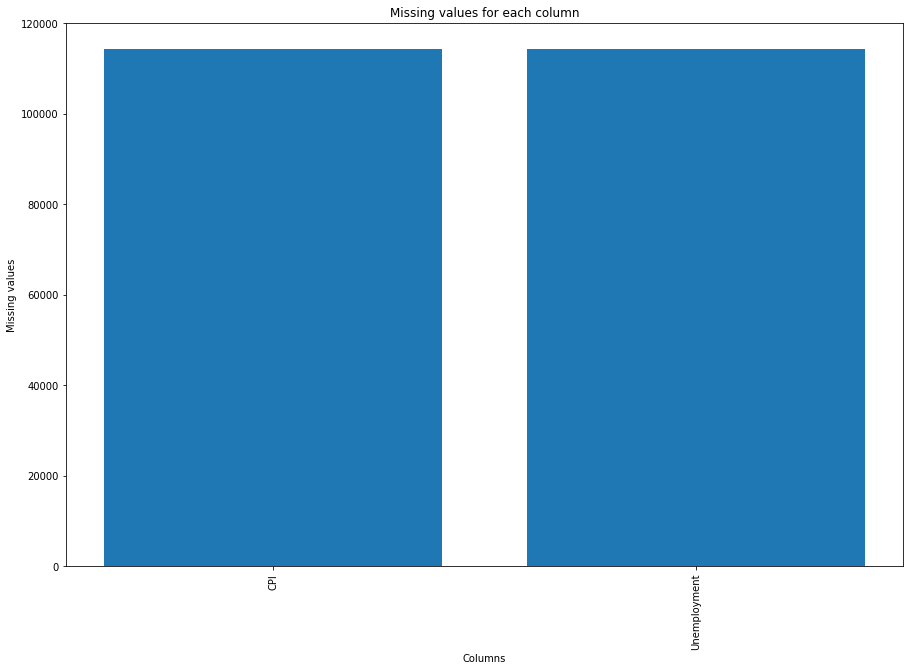

In [104]:
missing = []
headers_missing = []
for series in list(data):
    if data[series].isnull().sum() != 0:
        missing.append(data[series].isnull().sum())
        headers_missing.append(series)        
plt.figure(figsize=(15,10))
plt.title("Missing values for each column")
plt.xlabel("Columns")
plt.ylabel("Missing values")
plt.bar(headers_missing, missing)
plt.xticks(rotation=90);

Isnull is an additional way to identify missing values, as a supplement to the previous cell.

In [105]:
isnull = data.isnull().sum()
isnullsort= isnull.sort_values()
isnullsort 

Store                0
Size                 0
A                    0
B                    0
C                    0
Temperature          0
Fuel_Price           0
IsHoliday            0
week_no              0
Dept                 0
Weekly_Sales         0
index                0
CPI             114431
Unemployment    114431
dtype: int64

In [237]:
data.head()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales,index
0,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,15984.24,0
1,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,16567.69,1
2,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,43202.29,2
3,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,44481.38,3
4,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,3,15808.15,4


Repeating the visualization of missing values. 

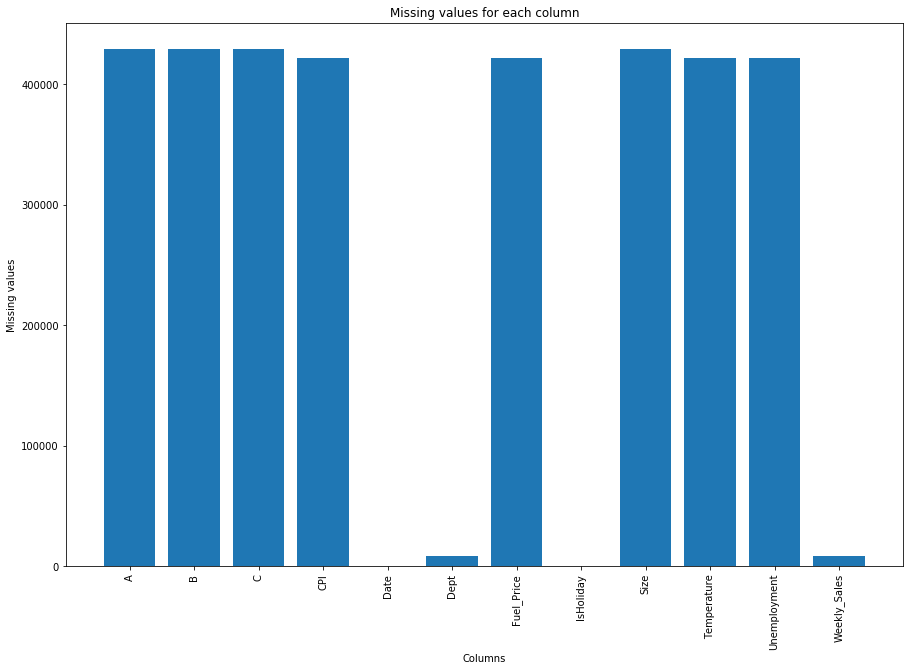

In [22]:
missing = []
headers_missing = []
for series in list(data):
    if data[series].isnull().sum() != 0:
        missing.append(data[series].isnull().sum())
        headers_missing.append(series)        
plt.figure(figsize=(15,10))
plt.title("Missing values for each column")
plt.xlabel("Columns")
plt.ylabel("Missing values")
plt.bar(headers_missing, missing)
plt.xticks(rotation=90);

When I have uncovered where my dataset has missing values, I find ways to handle this, by 'imputing' sensible values. 
There are different ways to do this, ranging from deleting rows, filling with '0' - or using more sophisticated
algorithms to provide realistic values. I choose a middle way, filling the 'gaps' with mean or median values.
The choice is made based on my assumption of the data and its importance for the analysis.  

In [80]:
data.Unemployment.describe()

count    7605.000000
mean        7.826821
std         1.877259
min         3.684000
25%         6.634000
50%         7.806000
75%         8.567000
max        14.313000
Name: Unemployment, dtype: float64

The 'Unemployment' columns is filled with mean values. 

In [238]:
mean = data["Unemployment"].mean()
data.Unemployment.fillna(mean, inplace=True)

I made some design changes between first and second run of coding. 
Below I have kept some imputation code that became obsolete, for the sake of documenting some tryouts.   

In [24]:
#mean2 = data["Fuel_Price"].mean()
#data.Fuel_Price.fillna(mean2, inplace=True)

In [25]:
#mean3 = data["Temperature"].mean()
#data.Temperature.fillna(mean3, inplace=True)

In [27]:
#mean4 = data["Size"].mean()
#data.Size.fillna(mean4, inplace=True)

The column 'CPI' is filled with mean values. 
I had to Google the meaning of CPI (I am Norwegian) to get an understanding of this column.

In [240]:
mean6 = data["CPI"].mean()
data.CPI.fillna(mean6, inplace=True)

In [108]:
#mean7 = data["Dept"].median()
#data.Dept.fillna(mean7, inplace=True)

In [256]:
#mean8 = data["Weekly_Sales"].mean()
#data.Weekly_Sales.fillna(mean8, inplace=True)

In [257]:
#mean9 = data["IsHoliday"].median()
#data.IsHoliday.fillna(mean9, inplace=True)

In [258]:
#mean10 = data['Weekly_Sales'].mean()
#mean10

15981.258123465912

Checking out my dataset is in shape and with the expected values

In [242]:
data.head()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales,index
0,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,15984.24,0
1,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,16567.69,1
2,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,43202.29,2
3,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,44481.38,3
4,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,3,15808.15,4


Checking out all the missing values are handled 

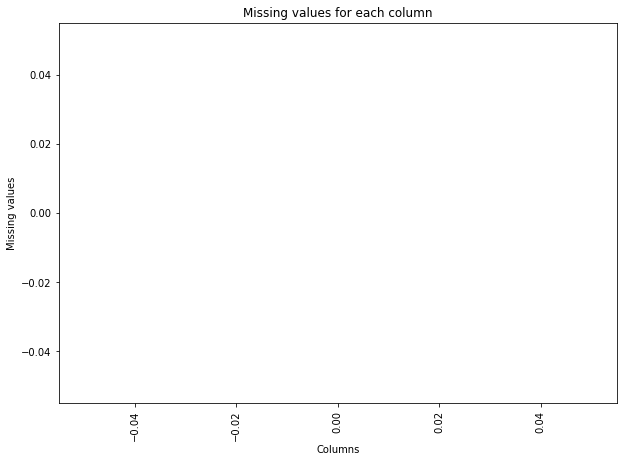

In [243]:
missing = []
headers_missing = []
for series in list(data):
    if data[series].isnull().sum() != 0:
        missing.append(data[series].isnull().sum())
        headers_missing.append(series)        
plt.figure(figsize=(10,7))
plt.title("Missing values for each column")
plt.xlabel("Columns")
plt.ylabel("Missing values")
plt.bar(headers_missing, missing)
plt.xticks(rotation=90);

In [ ]:
FIgure above shows missing values. I rerun the plot until empty. 
In addition, I use the data.info() to confirm the resultrs (below)

In [179]:
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494450 entries, 0 to 1494449
Data columns (total 13 columns):
Store           1494450 non-null int64
Size            1494450 non-null int64
A               1494450 non-null uint8
B               1494450 non-null uint8
C               1494450 non-null uint8
Temperature     1494450 non-null float64
Fuel_Price      1494450 non-null float64
CPI             1494450 non-null float64
Unemployment    1494450 non-null float64
IsHoliday       1494450 non-null object
week_no         1494450 non-null int64
Dept            1494450 non-null int64
Weekly_Sales    1494450 non-null float64
dtypes: float64(5), int64(4), object(1), uint8(3)
memory usage: 129.7+ MB


After some challenges with mismatch of column number in the final steps of the code, I have realized it is vital to make 
a copy of the dataset with the original shape at this step, including the index column. I call it data_orig 

In [244]:
data_orig= data

The Index column is not useful for the next steps, as is data does not give relevant information. 
The column is therefore dropped.  

In [245]:
cols3 = ['index']
data.drop(cols3, axis=1, inplace=True)

'data_full' is another copy of the main dataset 'data', in case this is needed when working with the code. 

In [115]:
data_full = data
data_full.head()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales
0,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,15984.24
1,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,16567.69
2,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,43202.29
3,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,44481.38
4,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,3,15808.15


In [314]:
At this point the data is fully cleaned and ready for transformation.

### DATA TRANSFORMATION AND SCALING

In [ ]:
The data will here be scaled for usability in the next steps, using StandardScaler. 
The object 'scaler' is established for reuse later in the process. 
The dataframe 'data_ss' is the result of the scaling. 

In [246]:
scaler = p.StandardScaler().fit(data)

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494450 entries, 0 to 1494449
Data columns (total 13 columns):
Store           1494450 non-null int64
Size            1494450 non-null int64
A               1494450 non-null uint8
B               1494450 non-null uint8
C               1494450 non-null uint8
Temperature     1494450 non-null float64
Fuel_Price      1494450 non-null float64
CPI             1494450 non-null float64
Unemployment    1494450 non-null float64
IsHoliday       1494450 non-null object
week_no         1494450 non-null int64
Dept            1494450 non-null int64
Weekly_Sales    1494450 non-null float64
dtypes: float64(5), int64(4), object(1), uint8(3)
memory usage: 129.7+ MB


In [181]:
data_ss = scaler.transform(data)

In [182]:
data_ss = pd.DataFrame(data_ss)

In [183]:
data_ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494450 entries, 0 to 1494449
Data columns (total 13 columns):
0     1494450 non-null float64
1     1494450 non-null float64
2     1494450 non-null float64
3     1494450 non-null float64
4     1494450 non-null float64
5     1494450 non-null float64
6     1494450 non-null float64
7     1494450 non-null float64
8     1494450 non-null float64
9     1494450 non-null float64
10    1494450 non-null float64
11    1494450 non-null float64
12    1494450 non-null float64
dtypes: float64(13)
memory usage: 148.2 MB


Dataset scaled with StandardScaler

In [119]:
#pca=PCA(n)
#pca7=PCA(7)
#pca7

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

I here define a small function to do the pca calculations/transforms. 

In [121]:
def do_pca(n, data):
    ''' 
    do_pca takes the input dataset and the suggested pca value 
    and returns pca, pca_model, X_pca and X_pcadf
    the intention is to produce all neccessary objects for further use
    '''
        pca=PCA(n)
        pca_model = pca.fit(data)
        X_pca = pca.fit_transform(data)
        X_pcadf = pd.DataFrame(X_pca)
        return pca, pca_model, X_pca, X_pcadf

Below I use the do_pca function to get all pca object I need for the nest steps. 

Note that the value 7 is not arbitrarly picked here, but a result of the below calculation of pca value.

The cell was used with different pca values when coding and finally set to 7, which I left in the Notebook. 

In [122]:
pca7, pca_model7, X_pca7, X_pca7df = do_pca(7,data_ss)

In [184]:
X_pca7df

,0,1,2,3,4,5,6
0,1.466103,-1.041715,-0.106887,-1.624614,-0.929018,-0.791541,-1.401689
1,1.471699,-1.041666,-0.105315,-1.619607,-0.922919,-0.778304,-1.402190
2,1.727879,-1.037426,-0.032828,-1.388463,-0.637029,-0.149346,-1.426601
3,1.740145,-1.037319,-0.029383,-1.377486,-0.623658,-0.120329,-1.427699
4,1.465918,-1.037696,-0.105865,-1.620991,-0.915924,-0.746095,-1.404670
5,1.447869,-1.037853,-0.110934,-1.637143,-0.935598,-0.788793,-1.403055
6,1.678991,-1.033831,-0.045484,-1.428422,-0.677021,-0.219111,-1.425226
7,1.707550,-1.033582,-0.037463,-1.402865,-0.645891,-0.151552,-1.427780
8,1.533513,-1.033086,-0.085806,-1.556714,-0.828948,-0.540313,-1.413712
9,1.537407,-1.033052,-0.084712,-1.553228,-0.824703,-0.531099,-1.414061


The plotting of principal components for this dataset is very useful for picking the best pca value, 
even if a list of concatenated numbers will give the same information. 
I reran this plot for several values, and kept the one with 7 for illustrative purposes.  

The choice of 7 as a pca value does not add up to more than ca 80% , but I regard this as sufficient. 

In [125]:
def screen_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(8, 5))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component') 

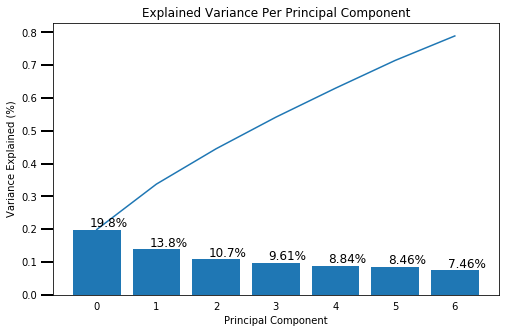

In [126]:
screen_plot(pca7)

In [127]:
var7=np.cumsum(np.round(pca7.explained_variance_ratio_, decimals=4)*100)
print(var7)

[19.9  33.76 44.54 54.16 63.01 71.48 78.95]


#### FInal choice and naming of variables after pca choice
Recalculating and giving names for later use (pca = pca7, X_pca = X_pca 7)

In [155]:
#pca7, pca_model7, X_pca7, X_pca7df = do_pca(7,data_ss)
pca, pca_model, X_pca, X_pcadf = do_pca(7, data_ss)

In [156]:
X_pcadf= pd.DataFrame(X_pca)
X_pcadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494450 entries, 0 to 1494449
Data columns (total 7 columns):
0    1494450 non-null float64
1    1494450 non-null float64
2    1494450 non-null float64
3    1494450 non-null float64
4    1494450 non-null float64
5    1494450 non-null float64
6    1494450 non-null float64
dtypes: float64(7)
memory usage: 79.8 MB


In [ ]:
Next cell whows the calculation of pca weights.

In [186]:
def pca_weights(full_dataset, pca, pca_n):
    ''' Function calculates pca weights for the dataset, the pca model and a chosen pca value'''
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    return components.loc[pca_n, :].sort_values(ascending=False)

In [185]:
data.head()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales
0,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,15984.24
1,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,16567.69
2,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,43202.29
3,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,44481.38
4,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,3,15808.15


Below is shown the pca weights for the three first components.

It shows which values are dominant (high positive and high negative values). 

This is central for evaluating the result of the data analysis.   

In [187]:
pca_weights(data, pca, 0)

A               0.5835
Size            0.5543
Weekly_Sales    0.2167
CPI             0.0908
Dept            0.0229
IsHoliday       0.0050
week_no         0.0019
Temperature    -0.0080
Fuel_Price     -0.0330
Unemployment   -0.1194
Store          -0.1416
C              -0.3065
B              -0.4090
Name: 0, dtype: float64

In [188]:
pca_weights(data, pca, 1)

Store           0.5376
C               0.5066
Unemployment    0.3147
Temperature     0.1920
A               0.1786
week_no         0.0662
Dept            0.0615
Fuel_Price      0.0453
Weekly_Sales    0.0019
IsHoliday      -0.0366
Size           -0.0401
CPI            -0.1636
B              -0.4966
Name: 1, dtype: float64

In [133]:
pca_weights(data, pca, 2)

Unemployment    0.2175
Store           0.1882
Fuel_Price      0.1821
Size            0.1396
B               0.0961
IsHoliday       0.0900
Weekly_Sales    0.0609
Dept            0.0228
A               0.0073
C              -0.1674
week_no        -0.3925
Temperature    -0.5663
CPI            -0.5832
Name: 2, dtype: float64

Discussions on PCA by looking at the pca components above.

I chose 7 principal components based on the numbers shown above, even though 7 may seem a bit too much for a dataset with only 10 columns. 

From the 3 first components, I can deduce that the store type is important for clustering, particularly storetype A, C and 'not B' (high negative value).

Unemployment rate seems to be the most important non-store related component, and Temperature the other of any relevance. 

### DATA MODELING BY CLUSTERING 

In the previous step I chose to use 7 principal components.

I take the result from this to the next step; clustering on dataset with Kmeans.

I start with making a small function for establishing the kmean object, in the same way I did for pca. 

fit_kmeans takes the dataset and a proposed number for centers and returns a kmean model, a fitted model and labels.

The function will be iterated for identifying the best number of centers, similar to what I did for pca. 

In [134]:
def fit_kmeans(data, centers):
    ''' this function uses the KMeans function (imported from library)
    Input is dataset and kmeans value, output is 3 objects; kmeans, model and labels '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    labels = model.predict(data)
    return kmeans, model, labels

Below I try out the fit_kmeans function

In [79]:
kmeans3, model3, labels3 = fit_kmeans(X_pcadf, 3) 

In [86]:
score5 = model5.score(data)
score5

-17432715142482.059

To find the best choice of centers we need to evaluate the score value from the dataset and proposed center number.

The code for calculation and plotting this (below) is a computation-intensive code which takes time to run through 
and does not invite to frequent reruns. 

The best center value is normally where the curve flattens out, creating the desired 'elbow' 
where we get diminishing returns by adding more centers, in the aim to reduce distance to cluster centers.

For this data, there is no clear elbow value, I choose to go with 7 centers, a pretty good value by the plot. 

1 15335638.19968408
2 11750269.950632647
3 9543867.78490078
4 8550329.193585929
5 8034460.539239899
6 7238089.958743464
7 6753928.799290387
8 6299962.485617581
10 5674898.901712613
12 5263575.091000828
14 4874314.463723929


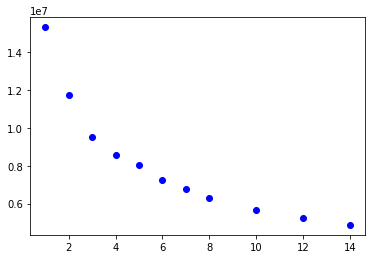

In [135]:
datax = X_pcadf

for centers in (1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14 ):
    kmeans, model, labels = fit_kmeans(datax, centers)
    score = model.score(data)
    print(centers, abs(score)) 
    plt.plot(centers, abs(score), linestyle='-', marker='o', color='b')

The above figure shows a slope rather than an albow, I choose to go forward with 7 clusters. 

With the value 7, I calculate the kmeans objects. 

In [136]:
kmeans7, model7, label7 = fit_kmeans(X_pcadf, 7)

In [150]:
#kmeans7
#model7
label7

array([0, 0, 0, ..., 6, 6, 6])

Adding the cluster column using the labels assigns the data to the clusters, here to the scaled dataset 

In [189]:
X_pcadf['clusters'] = label7
X_pcadf.head()

,0,1,2,3,4,5,6,clusters
0,1.466103,-1.041715,-0.106887,-1.624614,-0.929018,-0.791541,-1.401689,0
1,1.471699,-1.041666,-0.105315,-1.619607,-0.922919,-0.778304,-1.402190,0
2,1.727879,-1.037426,-0.032828,-1.388463,-0.637029,-0.149346,-1.426601,0
3,1.740145,-1.037319,-0.029383,-1.377486,-0.623658,-0.120329,-1.427699,0
4,1.465918,-1.037696,-0.105865,-1.620991,-0.915924,-0.746095,-1.404670,0


Adding the cluster labels to the unscaled dataset gives a good picture of the data belonging to the clusters

In [190]:
data['clusters'] = label7
data.head()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales,clusters
0,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,15984.24,0
1,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,1,16567.69,0
2,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,43202.29,0
3,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,2,44481.38,0
4,1,151315,1,0,0,48.27,2.976,211.404742,7.742,0,1,3,15808.15,0


Finally, grouping the data by clusters and showing mean values give additional insight

In [191]:
data.groupby(['clusters']).mean()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,week_no,Dept,Weekly_Sales
clusters,,,,,,,,,,,,
0,14.170857,182946.893201,1.000000,0.000000,0.000000,69.564189,3.256566,206.274693,7.154640,27.207068,35.927281,13364.030904
1,27.909510,179509.091072,1.000000,0.000000,0.000000,54.713584,3.524339,151.355347,8.069698,21.410935,34.979069,11272.338836
2,17.742898,101506.430072,0.000000,1.000000,0.000000,66.951615,3.463115,169.895820,7.911517,31.150209,42.676488,12331.243224
3,21.024884,187150.584263,0.992921,0.007079,0.000000,61.563501,3.419707,172.825560,7.604921,25.030551,83.732625,54552.387903
4,38.948856,40531.903456,0.000000,0.000000,1.000000,68.048803,3.412519,171.263782,8.654890,24.207178,46.893596,9517.896224
5,19.836934,102385.149784,0.000038,0.999962,0.000000,41.324794,3.421396,165.190521,7.579438,10.522732,43.830114,11182.016771
6,20.863791,143980.216052,0.548976,0.424038,0.026987,47.487945,3.285612,172.396911,7.648386,30.535042,43.439833,15704.588248


The 2 next cells clusters and groups the scaled version of the data
- not very readable, but OK to confirm the result for this vetrsion of the data, too 

In [192]:
X_pcadf.groupby(['clusters']).mean()

,0,1,2,3,4,5,6
clusters,,,,,,,
0,1.609034,-0.141839,-1.103368,-0.224086,-0.321279,-0.356514,-0.254226
1,1.198049,0.678067,0.773383,0.014396,-0.474740,-0.528502,0.036054
2,-1.333340,-0.998545,-0.348456,0.834670,0.050845,-0.053333,-0.064972
3,1.869163,0.378401,0.103203,0.476330,0.443757,1.674285,-0.140544
4,-2.366500,2.731262,-0.701597,-0.899474,-0.132129,0.451970,0.143040
5,-1.336426,-1.317626,1.075674,-0.460025,-0.443501,0.297049,-0.349631
6,0.213305,-0.493504,0.518824,-1.061044,2.899441,-0.812990,1.559627


In [193]:
data.groupby(['clusters']).mean()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,week_no,Dept,Weekly_Sales
clusters,,,,,,,,,,,,
0,14.170857,182946.893201,1.000000,0.000000,0.000000,69.564189,3.256566,206.274693,7.154640,27.207068,35.927281,13364.030904
1,27.909510,179509.091072,1.000000,0.000000,0.000000,54.713584,3.524339,151.355347,8.069698,21.410935,34.979069,11272.338836
2,17.742898,101506.430072,0.000000,1.000000,0.000000,66.951615,3.463115,169.895820,7.911517,31.150209,42.676488,12331.243224
3,21.024884,187150.584263,0.992921,0.007079,0.000000,61.563501,3.419707,172.825560,7.604921,25.030551,83.732625,54552.387903
4,38.948856,40531.903456,0.000000,0.000000,1.000000,68.048803,3.412519,171.263782,8.654890,24.207178,46.893596,9517.896224
5,19.836934,102385.149784,0.000038,0.999962,0.000000,41.324794,3.421396,165.190521,7.579438,10.522732,43.830114,11182.016771
6,20.863791,143980.216052,0.548976,0.424038,0.026987,47.487945,3.285612,172.396911,7.648386,30.535042,43.439833,15704.588248


Lastly for this step, I want the distribution of values for the dataset into the clusters.

This is done by using predictions, also named labels (a bit confusing, these names).

The result is shown both by numbers and by a plot. 

In [141]:
predictions = label7

Rows: 1494450
Rows per cluster:
6     88636
3    138162
4    148679
5    183417
0    253429
1    324545
2    357582
Name: CLUSTER_ID, dtype: int64


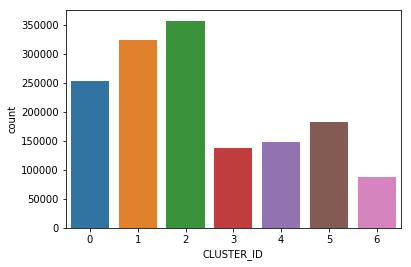

In [194]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['CLUSTER_ID']
print('Rows: {}'.format(predictions_df.shape[0]))
print('Rows per cluster:')
print(predictions_df.CLUSTER_ID.value_counts().sort_values())
sns.countplot(predictions_df.CLUSTER_ID);

In [3]:
#X_pcadf.info()

With a callback to a comment on index column earlier, I add the index column here 
to be able to match datasets by the correct dimension

In [198]:
dataix=data
dataix['index']=dataix.index
dataix.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1494440, 1494441, 1494442, 1494443, 1494444, 1494445, 1494446,
            1494447, 1494448, 1494449],
           dtype='int64', length=1494450)

Below is the final coding for interpreting the results, an inverse transformation to produce the 
information about the data, seen by cluster. 

If one cares to inspect the frames closelym, there is a small diffenece in numbers.
The reason for this is (I think) that the index column is included in one of the frames, but not in the other.

The interpretation of these results alongside with the visual representation of the clusters
is basis for the final comments below. 

In [195]:
cluster_7 = scaler.inverse_transform(pca.inverse_transform(kmeans7.cluster_centers_))

In [201]:
data.groupby(['clusters']).mean()

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,week_no,Dept,Weekly_Sales,index
clusters,,,,,,,,,,,,,
0,14.170857,182946.893201,1.000000,0.000000,0.000000,69.564189,3.256566,206.274693,7.154640,27.207068,35.927281,13364.030904,4.738419e+05
1,27.909510,179509.091072,1.000000,0.000000,0.000000,54.713584,3.524339,151.355347,8.069698,21.410935,34.979069,11272.338836,9.444625e+05
2,17.742898,101506.430072,0.000000,1.000000,0.000000,66.951615,3.463115,169.895820,7.911517,31.150209,42.676488,12331.243224,6.021503e+05
3,21.024884,187150.584263,0.992921,0.007079,0.000000,61.563501,3.419707,172.825560,7.604921,25.030551,83.732625,54552.387903,7.100509e+05
4,38.948856,40531.903456,0.000000,0.000000,1.000000,68.048803,3.412519,171.263782,8.654890,24.207178,46.893596,9517.896224,1.299203e+06
5,19.836934,102385.149784,0.000038,0.999962,0.000000,41.324794,3.421396,165.190521,7.579438,10.522732,43.830114,11182.016771,6.590400e+05
6,20.863791,143980.216052,0.548976,0.424038,0.026987,47.487945,3.285612,172.396911,7.648386,30.535042,43.439833,15704.588248,7.064879e+05


In [364]:
cluster_7 = scaler.inverse_transform(pca.inverse_transform(kmeans7.cluster_centers_))

In [248]:
c_7 = pd.DataFrame(data=cluster_7,
         index=np.array(range(0, cluster_7.shape[0])),columns=data_orig.columns)

c_7.head(10)

,Store,Size,A,B,C,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_no,Dept,Weekly_Sales
0,15.719292,183093.344367,0.992774,0.020911,-0.013685,70.100454,3.234999,205.966361,7.039662,-0.007183,27.277746,33.752812,15592.423416
1,26.756201,185541.253286,0.959513,0.004015,0.036472,55.555630,3.552628,154.070138,8.228765,0.025367,19.833909,31.431424,14300.011516
2,15.216765,97668.505493,0.012124,0.964357,0.023519,67.282870,3.489233,169.118005,8.038569,0.021165,30.095227,42.427713,12247.343804
3,20.121992,193081.747158,0.988358,0.004371,0.007271,62.299724,3.434770,172.880780,7.687430,0.025955,24.460851,89.197642,49133.812034
4,45.454541,34507.724333,0.066615,0.072498,0.860887,69.783231,3.395757,177.602108,8.661091,0.047562,24.477399,54.355311,4052.643929
5,18.370695,99352.662328,0.014014,0.974122,0.011865,41.674923,3.417000,161.622865,7.524567,0.003625,10.310499,44.767146,10055.766840
6,24.383239,144071.352206,0.535423,0.429411,0.035166,36.774764,3.152132,163.150805,6.857447,0.818755,41.250282,40.494203,18424.278748


### EVALUATE THE RESULTS AND COMMENT ON THE PROCESS

I did several transformation on the data, using in the first round both the Train set and the Test set, for comparing purposes.

The data handling was useful and interesting , although the analysis and insight is a bit limited due to some of the choices I made in the cleaning and transformation.

The main purpose was to establish useful clusters of data for the stores, using the techniques learned. I also wanted to compare Train and Test data.  

I cleaned all the variables to be able to perform calculations, entering mean or median values for many of them, and dropping several columns. The remaining dataset was taken through PCA Dimension Reduction and KMeans- based clustering. I performed the same steps on the Test dataset and compared the two sets. 

After redoing quite a lot with the main dataset I decided to drop the test dataset analysis, as it seemed to give little additional insight. All code related to test data was removed completely. 
 
I can see now that some of the cleaning steps in first round were unsuitable for insight and should have been chosen differently. I went back and recoded quite a lot. 

Store and Dept do not represent size or other numerical values, but are rather categorical and it would have been better to encode these so several variables. The same goes for Type - this i recided, useing one-hot encoding. The new columns showed to be important in the clustering.  

CLUSTERS:
Cluster 3 and 4 are clearly clustered by weekly sales, representing the largest and lowest numbers. Store Type A has the highest numbers, Type B the lowest. This is an insight I also got from the PCA component viewings. Cluster 4 with low weekly sales also has the highest Unemployment rate, the smallest stores - and the second highest mean temperature.   

Overall the clusters are strongly correlated to the store type, except for cluster 6. 
  


### EVALUATE THE RESULTS; ANSWERING THE INITIAL BUSINESS QUESTIONS

Answering my initial Business questions:

1) Can Unsupervised Learning methods be used for clustering data from the Kaggle Walmart dataset?
  (The dataset is originally posted for predicting sales, using time dimensions and other techniques)
    
    - Answer : Yes, the data can be used with Unsupervised Learning methods, 
        but it requires several choices and data cleaning/changing.  
  
2) Can I by using the pca method reduce dimensions on this dataset with acceptable results, 
   and will I be able to establish clear and sensible clusters for the dataset, to provide basis for business analysis?
    
    - Answer : Yes, the data (after transformation) shows that dimensions can be reduced and clusters established.
        If ha had spent more time polishing the data I think the value could be even better for these purposes 
   
3) Do the clusters provide me with valuable insight about the Walmart stores by grouping them differently than we do 
   by only using geography and store size?
    
    - Answer : Not so sure. The clusters clearly lean on the store types and sizes and their coreelation with weekly sales,
        which is not an eye-opener, I assume.
        
        I did see some correlation with Unemployment rates and (weakly) on temperature, which makes me curious as to the
        coonnection with geographical differences and related sociodemographical info where the stores reside. 
        
4) Can we identify variables that have a significant impact on the stores with outstanding high or low weekly sales? 

    - Answer : Yes, we can see from the clusters that 
                    - stores with low weekly sales are the smallest stores, type C, in areas with high unemployment rates
                    - stores with high weekly sales are large stores of type A with low unemployment areas. 
                    - genarally, the high-weekly-sale stores are in areas with lwoer temperatures, indicating northern areas
   